In [1]:
import pandas as pd
import numpy as np
import math
from random import randint
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bin_count = 30

train_size = 3 # in month
test_size = 1 # in month

In [3]:
# some parameters of learning
ita = 0.3 # table updating rate
epsilon = 0.2 # random
gamma = 0.4 # decline factor of late reward
trial_count = 30
rwd_penalty = 1

In [4]:
def close_to_state(close, closeUB, closeLB, bin_count): # convert close price to the state's first dimension value
    if close >= closeUB:
        return bin_count-1
    elif close <= closeLB:
        return 0
    bin_size = (closeUB - closeLB) / bin_count
    
    ret = math.floor((close - closeLB) / bin_size)
    if ret >= bin_count:
        return bin_count - 1
    elif ret < 0:
        return 0
    else:
        return math.floor((close - closeLB) / bin_size)

In [5]:
def valid_year_month(year, month, add_month):
    #if add_month > 12:
        #print('Error, valid_year_month can not handle add_month which is > 12')
    ret_year = year
    ret_month = month
    
    ret_month += add_month
    if ret_month > 12:
        while True:
            ret_year += 1
            ret_month = ret_month - 12
            if ret_month <= 12:
                break
        
    return [ret_year, ret_month]

In [6]:
def month_count(set_start, set_end): # include the two input month
    ret = 0
    ret += 12 - set_start.month + 1
    if set_end.year - set_start.year > 0:
        ret += 12*(set_end.year - set_start.year - 1)
    ret += set_end.month
    return ret

In [7]:
##### add: loop data

from os import listdir

inputFolderFormat = "./input/temp/{0}"
relist = listdir('./input/temp')

data_result = list()

resourceCount = 0

for resource_data in relist:
#resource_data = '1704.TW.csv'
#for i in range (0, 10):
#####

    resourceCount += 1
    print(resourceCount)

    input_csv = inputFolderFormat.format(resource_data)
    data = pd.read_csv(input_csv)
    
    data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    data = data.drop(index=0).reset_index(drop=True)
    data = data.drop(index=0).reset_index(drop=True)
    data = data.iloc[::-1].reset_index(drop=True)
    data.to_csv('file_name.csv', sep=',', index=False)
    data = pd.read_csv('file_name.csv')
    
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
    data['Close'] = data['Close'].fillna(method='ffill')
    data['Close'] = data['Close'].fillna(method='bfill')
    
    
    month_count_ret = month_count(data.iloc[0]['Date'], data.iloc[len(data)-1]['Date'])
    tt_count = math.floor((month_count_ret - 2 - train_size) / test_size)
    start_year = (data.iloc[0]['Date'] + pd.DateOffset(months= 2)).year
    start_month = (data.iloc[0]['Date'] + pd.DateOffset(months= 2)).month
    #print('tp1', start_year, start_month)

    test_gain = np.zeros(tt_count)

    
    last_testend_value = np.zeros(shape=(2)) # handCash, handStock
    last_testend_last_value = np.zeros(shape=(2)) # handCash, handStock
    last_testend_value = [10000, 0]
    last_testend_last_value = [10000, 0]
    last_testend_state = np.zeros(shape=(3), dtype=int)
    last_testend_action = 0

    table = np.zeros(shape=(bin_count, 3, 2, 2))

    for tt_ind in range(0, tt_count):

        # determine the close price data while training
        start_date = pd.datetime(start_year, start_month, 1)
        end_date = pd.datetime(valid_year_month(start_year, start_month, train_size)[0], 
                               valid_year_month(start_year, start_month, train_size)[1], 1)
        #print('tp2', start_date, end_date)

        close = data.loc[(start_date <= data['Date']) & (data['Date'] < end_date)]['Close']
        close = close.values # Convert Series to Numpy-array

        closeUB = np.percentile(close, 95)
        closeLB = np.percentile(close, 5)
        remain_range = np.percentile(close, 52.5) - np.percentile(close, 47.5)

        # construct initial table
        # state is defined by: [closeprice, remain/bear/bull, withdraw/invest] : 10*3*2 + 2 actions: sell , buy
        table = np.zeros(shape=(bin_count, 3, 2, 2))
        state = np.zeros(shape=(3), dtype=int) # correspond to the table
        
        last_state = np.zeros(shape=(3), dtype=int)
        value = np.zeros(shape=(2)) # handCash, handStock
        last_value = np.zeros(shape=(2)) # handCash, handStock
        last_action = 0 # 0:sell 1:buy

        for trial in range(0, trial_count):

            last_state = [close_to_state(close[0], closeUB, closeLB, bin_count), 0, 0]
            #state = [close_to_state(close[0], closeUB, closeLB, bin_count), 0, 0]
            last_value = [10000, 0]
            value = [10000, 0]



            for point in range(1, len(close)):

                # determine the new state
                state[0] = close_to_state(close[point], closeUB, closeLB, bin_count)

                if close[point] - close[point-1] > remain_range:
                    state[1] = 2
                elif remain_range >= close[point] - close[point-1] >= (-1)*remain_range:
                    state[1] = 0
                elif close[point] - close[point-1] < (-1)*remain_range:
                    state[1] = 1

                if value[0] > 0 and value[1] == 0:
                    state[2] = 0 # withdraw
                    #print("handCash = ", value[0], " handStock = ", value[1], " point = ", point)
                elif value[0] == 0 and value[1] > 0:
                    state[2] = 1 # invest
                    #print("handCash = ", value[0], " handStock = ", value[1], " point = ", point)
                else:
                    print("abnormal, handCash = ", value[0], " handStock = ", value[1], " point = ", point)


                # get reward and update the table
                if table[state[0]][state[1]][state[2]][0] >= table[state[0]][state[1]][state[2]][1]:
                    best_action = 0
                else:
                    best_action = 1
                reward = (value[0] + value[1]*close[point]) - (last_value[0] + last_value[1]*close[point-1])
                if reward > 0:
                    reward *= rwd_penalty
                    
                table[last_state[0]][last_state[1]][last_state[2]][last_action] = \
                    (1 - ita) * table[last_state[0]][last_state[1]][last_state[2]][last_action] + \
                    ita * (reward + gamma * table[state[0]][state[1]][state[2]][best_action])    


                last_value = value.copy()
                last_state = state.copy()


                # decide current action : random/lookup-table
                if randint(1, 10) <= 10*epsilon:
                        # act randomly
                        last_action = randint(0, 1)
                else:
                    # or last_action = best_action
                    if table[state[0]][state[1]][state[2]][0] >= table[state[0]][state[1]][state[2]][1]: 
                        # sell stock
                        last_action = 0
                    elif table[state[0]][state[1]][state[2]][0] < table[state[0]][state[1]][state[2]][1]: 
                        # buy stock
                        last_action = 1

                if last_action == 0:
                    value[0] += value[1] * close[point]
                    value[1] = 0
                elif last_action == 1:
                    value[1] += value[0] / close[point]
                    value[0] = 0

            #print("trial = ", trial, " total value = ", value[0] + value[1]*close[point] - 10000)
            


        # determine the close price data while testing
        start_date = end_date
        end_date = pd.datetime(valid_year_month(start_year, start_month, train_size + test_size)[0], 
                               valid_year_month(start_year, start_month, train_size + test_size)[1], 1)
        #print('tp3', start_date, end_date)
        close = data.loc[(start_date <= data['Date']) & (data['Date'] < end_date)]['Close']
        close = close.values # Convert Series to Numpy-array

        #print('tp4', last_testend_value)
        value = last_testend_value
        last_value = last_testend_last_value
        last_action = last_testend_action
        if tt_count == 0:
            last_state = [close_to_state(close[0], closeUB, closeLB, bin_count), 0, 0]
        else:
            last_state = last_testend_state

        epsilon = 0.2

        for point in range(1, len(close)):

            # determine the new state
            state[0] = close_to_state(close[point], closeUB, closeLB, bin_count)

            if close[point] - close[point-1] > remain_range:
                state[1] = 2
            elif remain_range >= close[point] - close[point-1] >= (-1)*remain_range:
                state[1] = 0
            elif close[point] - close[point-1] < (-1)*remain_range:
                state[1] = 1

            if value[0] > 0 and value[1] == 0:
                state[2] = 0 # withdraw
                #print("handCash = ", value[0], " handStock = ", value[1], " point = ", point)
            elif value[0] == 0 and value[1] > 0:
                state[2] = 1 # invest
                #print("handCash = ", value[0], " handStock = ", value[1], " point = ", point)
            else:
                print("abnormal, handCash = ", value[0], " handStock = ", value[1], " point = ", point)


            # get reward and update the table
            if table[state[0]][state[1]][state[2]][0] >= table[state[0]][state[1]][state[2]][1]:
                best_action = 0
            else:
                best_action = 1
            reward = (value[0] + value[1]*close[point]) - (last_value[0] + last_value[1]*close[point-1])
            if reward > 0:
                reward *= rwd_penalty
            
            table[last_state[0]][last_state[1]][last_state[2]][last_action] = \
                (1 - ita) * table[last_state[0]][last_state[1]][last_state[2]][last_action] + \
                ita * (reward + gamma * table[state[0]][state[1]][state[2]][best_action])    


            last_value = value.copy()
            last_state = state.copy()


            # yet random
            if randint(1, 10) <= 10*epsilon:
                    # act randomly
                    last_action = randint(0, 1)
            else:
                # or last_action = best_action
                if table[state[0]][state[1]][state[2]][0] >= table[state[0]][state[1]][state[2]][1]: 
                    # sell stock
                    last_action = 0
                #elif table[state[0]][state[1]][state[2]][0] < table[state[0]][state[1]][state[2]][1]: 
                else:
                    # buy stock
                    last_action = 1

            if last_action == 0:
                value[0] += value[1] * close[point]
                value[1] = 0
            elif last_action == 1:
                value[1] += value[0] / close[point]
                value[0] = 0

        test_gain[tt_ind] = value[0] + value[1]*close[point] - 10000
        last_testend_value = value.copy()
        last_testend_last_value = last_value.copy()
        last_testend_state = last_state.copy()
        last_testend_action = last_action
        #print('tp5', last_testend_value)

        start_year = valid_year_month(start_year, start_month, test_size)[0]
        start_month = valid_year_month(start_year, start_month, test_size)[1]
    
    #print(resource_data, value[0] + value[1]*close[point] - 10000)
    data_result.append(value[0] + value[1]*close[point] - 10000)
print(data_result)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [8]:
print(closeUB ,( closeLB) , bin_count)
print(close)
print(start_year, start_month)

7.7325 5.0225 30
[7.89 7.78 7.76 7.69 7.72 8.15 8.2  7.95 7.87 7.85 7.98 7.89 7.99 8.17
 8.25 8.79 8.79]
2017 10


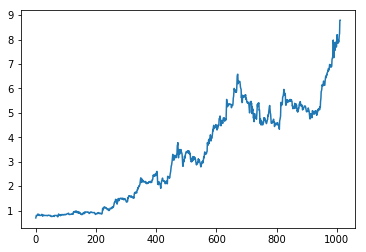

In [9]:
plt.plot(data['Close'])

array([ 1.71428571e+02,  6.03768780e+01,  1.57254581e+02, -3.62864730e+00,
        6.00663726e+01, -3.14427738e+02,  2.56091955e+02,  9.92501846e+02,
        8.45935155e+02,  8.45419296e+02,  9.87886713e+02,  9.28492731e+02,
        9.84791027e+02,  9.10759687e+02,  1.71263936e+03,  1.22499183e+03,
        2.77955976e+03,  2.52849681e+03,  4.25324934e+03,  3.69217268e+03,
        2.75938110e+03,  3.13223588e+03,  3.08184654e+03,  3.53137523e+03,
        2.59111290e+03,  2.47018937e+03,  1.69371469e+03,  1.72910502e+03,
        1.52037931e+03,  1.50863114e+03,  6.25333829e+02,  8.22997804e+02,
        7.28336887e+02,  1.06069865e+03,  1.15410904e+03,  1.02193115e+03,
        1.35607661e+03,  1.62718241e+03,  8.73272979e+02,  8.19977663e+02,
        1.18356032e+03,  2.46253518e+03,  2.79297420e+03])

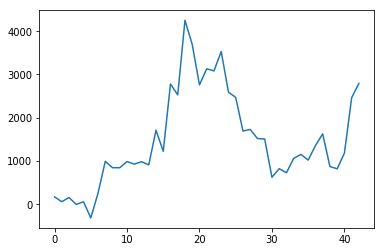

In [10]:
plt.plot(test_gain)
test_gain

In [11]:
test_gain.shape

(43,)

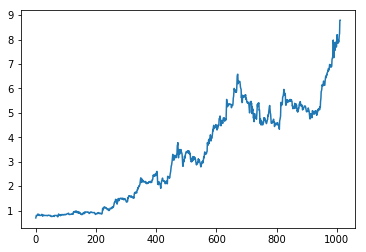

In [12]:
plt.plot(data['Close'])

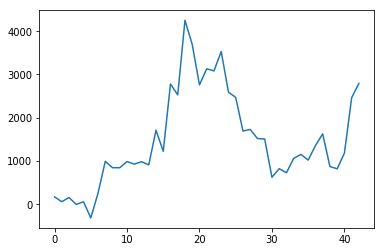

In [13]:
plt.plot(test_gain)

In [14]:
table.shape

(30, 3, 2, 2)

In [15]:
table

array([[[[ 1.38927192e+01,  9.57019603e+01],
         [ 1.24203564e+01, -3.14030623e+01]],

        [[ 0.00000000e+00,  1.14011701e+02],
         [ 5.91423122e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 4.17871454e+01, -3.47977875e+01],
         [ 9.49908893e+00, -3.72520413e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 1.44511900e+01,  1.92329446e+02],
         [ 0.00000000e+00,  6.57098872e+02]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0

In [16]:
len(close)

17

In [17]:
close[0:5]

array([7.89, 7.78, 7.76, 7.69, 7.72])

In [18]:
len(data_result)

1476

In [19]:
data_result

[-93.56367530115676,
 -2944.6201487761045,
 -1532.7691221399982,
 22567.55311279872,
 -4935.753623907877,
 2250.929983228716,
 -511.6676754375985,
 3495.9736817205485,
 -370.8512086235987,
 68505007.77024785,
 1497040.895061729,
 -142.59362683015388,
 7414.917298362798,
 399.09261894514384,
 -2844.777275155724,
 4681.064805683294,
 10233.920372926288,
 -433.6505837610566,
 1992577358.472188,
 -629.2904203888538,
 1736.0920578834066,
 17084.633673486664,
 -486.8256411813418,
 3513.226301264058,
 -2703.4362032781683,
 5191.589494118911,
 15337.096034108316,
 5053.867735949307,
 -714.547638644819,
 -822.5793193594018,
 137827.37622247948,
 -449.39625668288136,
 -2407.0410026739355,
 1827.342622280481,
 9200.951660534647,
 1050.2460683780937,
 4750.29509898146,
 6362.5338596253805,
 -3154.5209367771095,
 2778.10514397356,
 9644.685499430198,
 22744.22572478286,
 16309.224554260112,
 84885.05369311612,
 1566.9154526161656,
 2623.770561327885,
 2242.54127843103,
 47101.527379794716,
 918.476

In [20]:
state[0]

29

In [21]:
close_to_state(close[point], closeUB, closeLB, bin_count)

29